In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
import torchvision 
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys

In [14]:
batch_size = 128
input_dims = 100
epochs = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((128  , 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))
    ])
dataset = torchvision.datasets.ImageFolder("./dataset/butterflies" ,transform=TRANSFORM_IMG)

dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True, num_workers=4)

In [52]:
class Generator(nn.Module):
    def __init__(self, input_dims , dim = 4):
        super(Generator, self).__init__()

        def upsample_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
                nn.Conv2d(out_channels, out_channels , kernel_size = 4 , stride = 1, padding = 'same')
            )
        
        self.input_dims = input_dims
        self.input_layer = nn.Linear(input_dims , 64 * 4 *4)
        self.first = upsample_block(64 , 128)
        self.second = upsample_block(128 , 256)
        layers = [upsample_block(256 , 256) for _ in range(2)]
        self.middle = nn.Sequential(*layers)
        self.last = upsample_block(256 , 3)
        self.final = nn.Conv2d(3 , 3 , kernel_size = 3 , stride = 1 , padding = 'same')



    def forward(self, x):
        x = self.input_layer(x)
        x = x.view(x.size(0), 64, 4, 4)  # Reshape for ConvTranspose layers
        x = self.first(x)
        # print(x.shape)
        x = self.second(x)
        x = self.middle(x)
        x = self.last(x)
        x = self.final(x)
        # print(x.shape)
        x = torch.nn.functional.tanh(x)

        return x
    
class Critic(nn.Module):
    def __init__(self, output_dims):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=4, padding=1)
        # self.norm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=4, padding=1)
        # self.norm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=4, padding=1)
        # self.norm3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=4, padding=1)

        self.conv4 = nn.utils.spectral_norm(self.conv4)
        self.conv3 = nn.utils.spectral_norm(self.conv3)
        self.conv2 = nn.utils.spectral_norm(self.conv2)
        self.conv1 = nn.utils.spectral_norm(self.conv1)

        self.output_layer = nn.Linear(512*1*1, output_dims)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu((self.conv1(x)))
        x = torch.nn.functional.leaky_relu((self.conv2(x)))
        x = torch.nn.functional.leaky_relu((self.conv3(x)))
        x = torch.nn.functional.leaky_relu((self.conv4(x)))
        # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, features)
        return self.output_layer(x)

class DCGan(nn.Module):
    def __init__(self,input_dims =100, output_dims = 1):
        super(DCGan,self).__init__()
        self.gen = Generator(input_dims)
        self.critic = Critic(output_dims)

    def forward(self , latents , images):
        x = self.gen(latents)
        generated_y = self.critic(x)
        real_y = self.critic(images) 
        return real_y , generated_y

In [53]:
class DCTrainer():
    def __init__(self,model , dataloader , optim_gen , optim_critic  , epochs, device ,latent_dims, lambda_ = 5):
        self.model = model.to(device)
        self.dataloader = dataloader
        self.optim_gen = optim_gen 
        self.optim_critc = optim_critic
        self.epochs = epochs
        self.device = device
        self.lambda_ = lambda_
        self.latent_dims = latent_dims
        self.mvn = torch.distributions.MultivariateNormal( torch.zeros(latent_dims)  , torch.eye(latent_dims) )
    
    
    def latent_sampler(self ,batch_size ):
        samples = self.mvn.sample((batch_size,))
        return samples
    
    def W_loss_critic(self , real_y, gen_y,):
        real = torch.mean(real_y)
        fake = torch.mean(gen_y)
        return (fake - real) 
    
    def W_loss_gen(self , gen_y):
        return torch.mean(gen_y)

    def noramlize_weights(self ):
        for p in self.model.critic.parameters():
            p.data.clamp_(-1 ,1)

    def gradient_penalty(self , real , fake):
        alpha = torch.rand(real.shape[0], 1, 1, 1).to(self.device)
        interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        disc_interpolates = self.model.critic(interpolates)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train(self , starting = 0):
        for epoch in range(starting , self.epochs):
            loss_critic , loss_gen = self.train_step()
            print(f"Epoch {epoch} Generator Loss {loss_gen} Critic loss {loss_critic}")
            if(epoch%10 == 0):
               self.checkpoint(epoch)
            if(epoch%5 == 0):
                self.show()

    def train_step(self) :
        total_loss_critic = 0
        total_loss_gen = 0
        for i , (data , _) in enumerate(self.dataloader):
            data = data.to(self.device)
            self.optim_critc.zero_grad()
            self.optim_gen.zero_grad()
            z = self.latent_sampler(data.shape[0]).to(device=self.device)
            gen_data = self.model.gen(z).detach()

            gen_y   = self.model.critic(gen_data) 
            real_y = self.model.critic(data)
            loss_critic = self.W_loss_critic(real_y , gen_y) + self.lambda_ * self.gradient_penalty(data , gen_data)
            loss_critic.backward()
            self.optim_critc.step()
           # self.noramlize_weights()

            if( i% 5 == 0):
                z = self.latent_sampler(data.shape[0]).to(device=self.device)
            
                gen_data = self.model.gen(z)
                gen_y = self.model.critic(gen_data)
                loss_gen = torch.mean(gen_y)
                loss_gen.backward()
                self.optim_gen.step()
                
                total_loss_gen += loss_gen.item()
            total_loss_critic += loss_critic.item()
            
        return total_loss_critic/len(self.dataloader) , total_loss_gen/len(self.dataloader)
    
    def show(self , nx = 10 , e = 0 , images = None):
        if(images is None):
            images = self.generate_images(nx)
        images  = [images[i].permute(1,2,0).detach().cpu().numpy() for i in range(images.shape[0])]
        plt.figure(figsize=(3*nx, 2*nx))  # Adjust the size as needed

        # Loop through the images and display each one
        for i, image in enumerate(images):
            plt.subplot(nx//5 + nx%5, 5, i + 1)  # Change '1, 5' to the desired grid layout
            plt.imshow((image * 255).astype(np.uint8))
            plt.axis('off')  # This hides the axis

        plt.show()
        # plt.savefig(f"generated_{e}.png")

    def generate_images(self , number = 5):
        self.model.eval()
        with torch.no_grad():
            z = self.latent_sampler(number).to(device=self.device)
            images = self.model.gen(z)
            return images

    def checkpoint(self , epoch):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_critic_state_dict': self.optim_critc.state_dict(),
            'optimizer_gen_state_dict' : self.optim_gen.state_dict(),
            'epoch': epoch 
        }, f'RMSprop/checkpoint{epoch}.pth')

    def resume(self , path , iterations):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optim_critc.load_state_dict(checkpoint['optimizer_critic_state_dict'])
        self.optim_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
        epoch = checkpoint['epoch']+1
        self.epochs += iterations
        self.train(epoch)
        

In [54]:
model = DCGan(input_dims , output_dims=1).to(device=device)
learning_rate = 1e-4

optim_critc = torch.optim.RMSprop(model.critic.parameters() , learning_rate)
optim_gen = torch.optim.RMSprop(model.gen.parameters() , learning_rate)


Epoch 0 Generator Loss -8.5555431963238 Critic loss -51.27832159277511


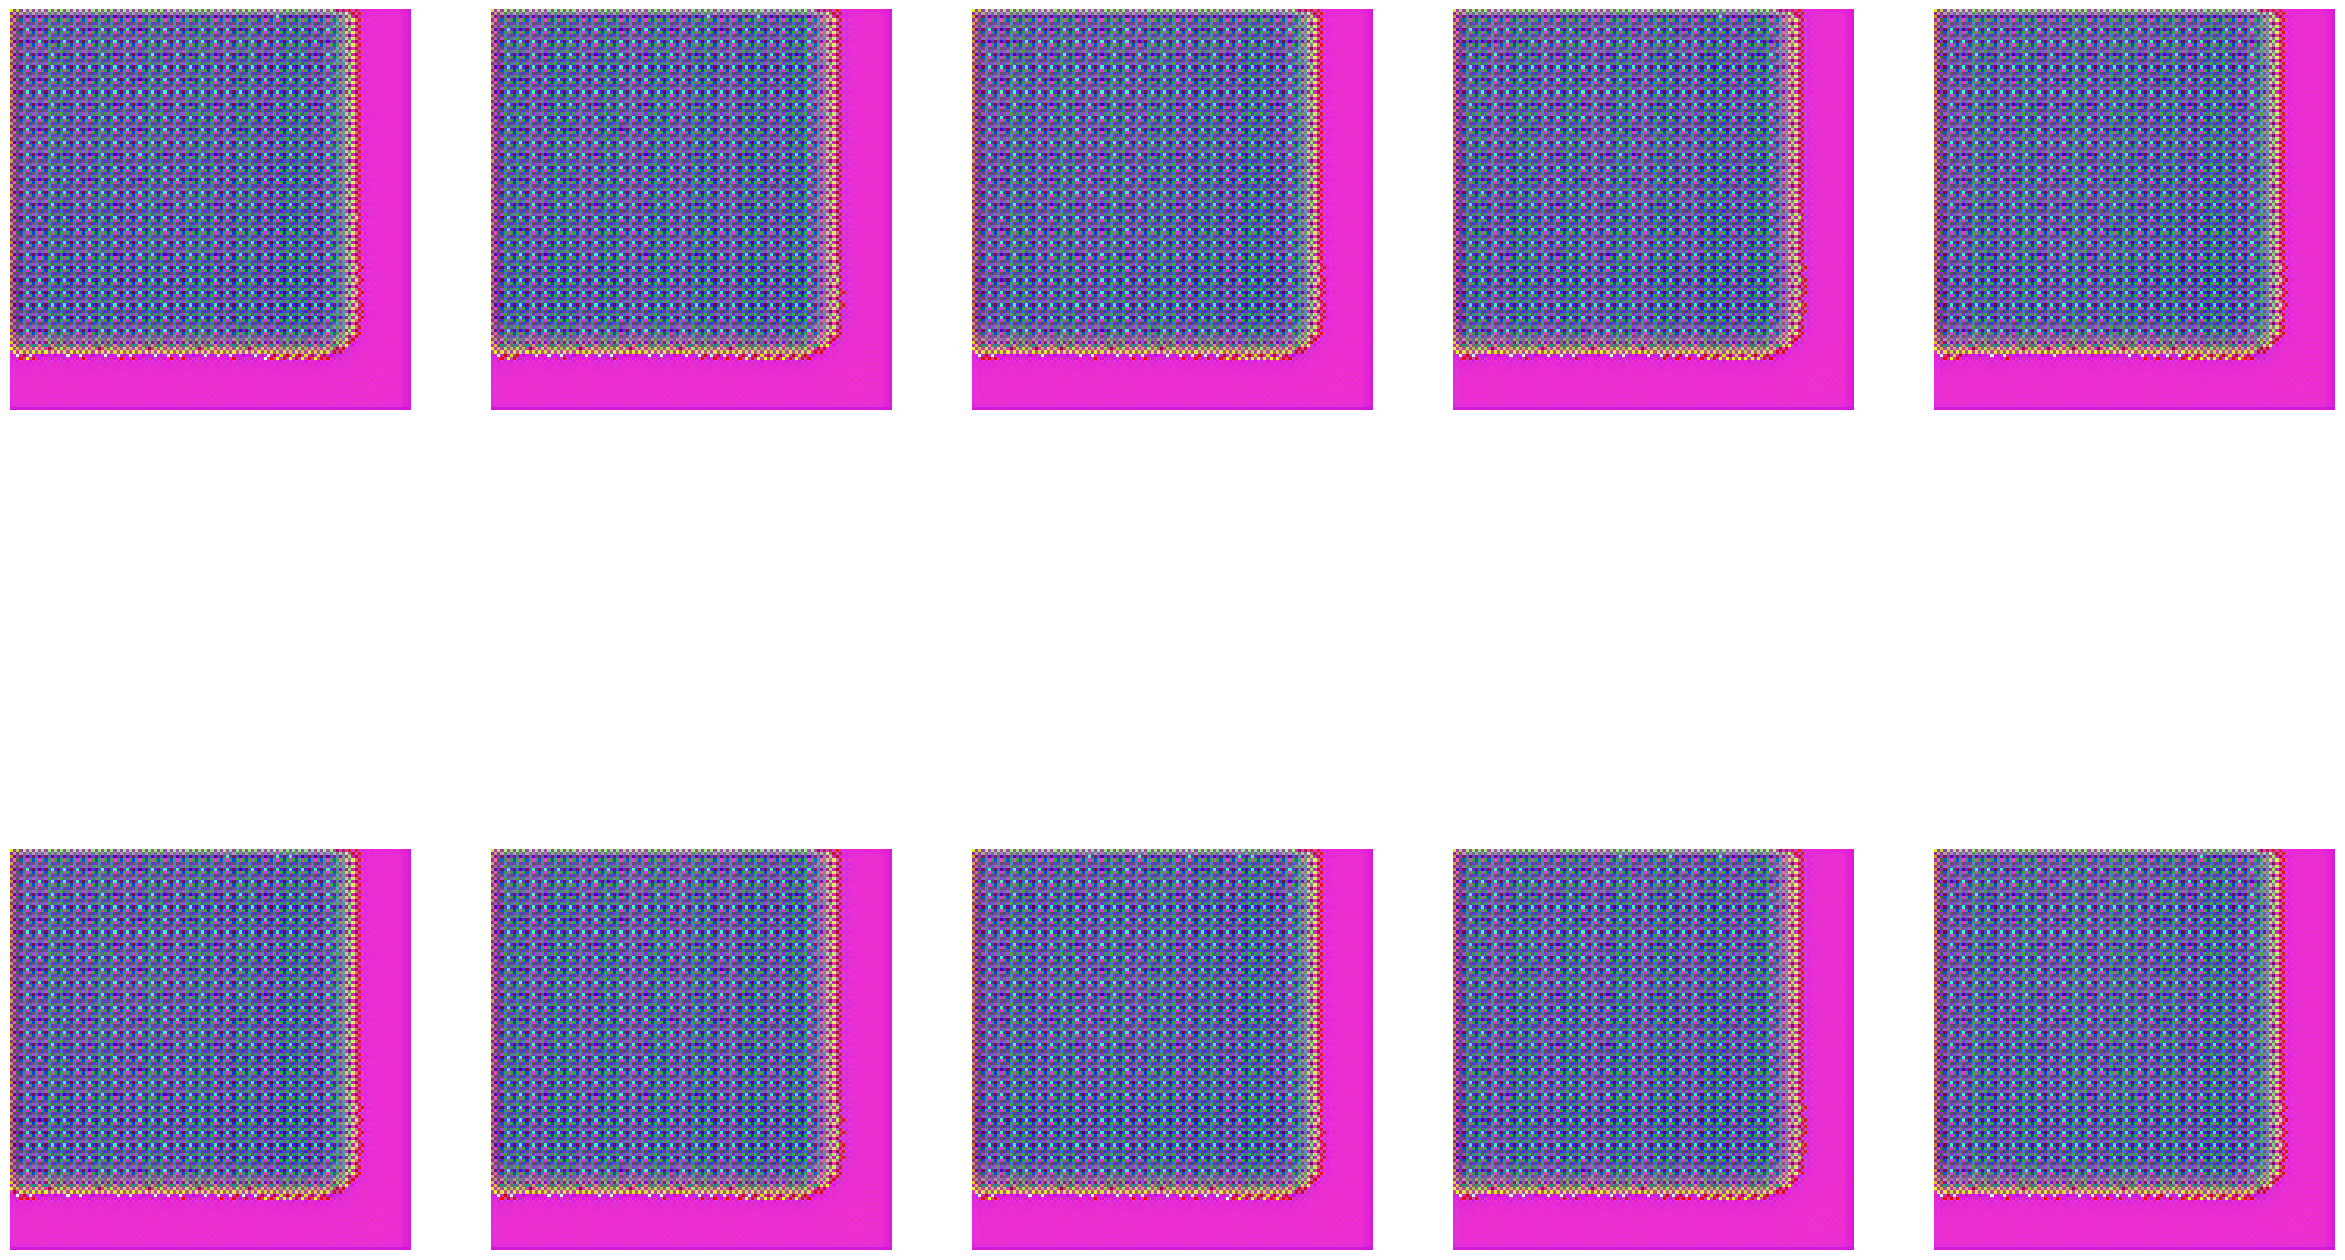

KeyboardInterrupt: 

In [55]:

trainer = DCTrainer(model , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims  ,lambda_=10)

# %%
# trainer.resume("newFolder/checkpoint100.pth" , 1000)
trainer.train()

In [ ]:
z = torch.randn(5,100)
print(z.shape)

for i in range(0, 125 , 10):
    checkpoint = torch.load(f"RMSprop/checkpoint100.pth" ,  map_location = device)
    model.load_state_dict(checkpoint['model_state_dict'])
    trainer = DCTrainer(model , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims  ,lambda_=10)
    y = model.gen(z.to(device))
    trainer.show(5 , i , y)
    

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import time as t
import matplotlib.pyplot as plt
import os
from torchvision import utils
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
import numpy as np

SAVE_PER_TIMES = 100

class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)


class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)


class WGAN_GP(object):
    def __init__(self, args):
        print("WGAN_GradientPenalty init model.")
        self.G = Generator(args['channels'])
        self.D = Discriminator(args['channels'])
        self.C = args['channels']

        # Check if cuda is available
        self.check_cuda(args['cuda'])

        # WGAN values from paper
        self.learning_rate = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.batch_size = 64

        # WGAN_gradient penalty uses ADAM
        self.d_optimizer = optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        self.g_optimizer = optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))

        self.number_of_images = 10

        self.generator_iters = 1000
        self.critic_iter = 5
        self.lambda_term = 10

    def get_torch_variable(self, arg):
        if self.cuda:
            return Variable(arg).cuda(self.cuda_index)
        else:
            return Variable(arg)

    def check_cuda(self, cuda_flag=False):
        print(cuda_flag)
        if cuda_flag:
            self.cuda_index = 7
            self.cuda = True
            self.D.cuda(self.cuda_index)
            self.G.cuda(self.cuda_index)
            print("Cuda enabled flag: {}".format(self.cuda))
        else:
            self.cuda = False


    def train(self, train_loader):

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(train_loader)

        one = torch.tensor(1, dtype=torch.float)
        mone = one * -1
        if self.cuda:
            one = one.cuda(self.cuda_index)
            mone = mone.cuda(self.cuda_index)

        for g_iter in range(self.generator_iters):
            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True

            d_loss_real = 0
            d_loss_fake = 0
            Wasserstein_D = 0
            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()

                images = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                images, z = self.get_torch_variable(images), self.get_torch_variable(z)

                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean()
                d_loss_real.backward(mone)

                # Train with fake images
                z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))

                fake_images = self.G(z)
                d_loss_fake = self.D(fake_images)
                d_loss_fake = d_loss_fake.mean()
                d_loss_fake.backward(one)

                # Train with gradient penalty
                gradient_penalty = self.calculate_gradient_penalty(images.data, fake_images.data)
                gradient_penalty.backward()


                d_loss = d_loss_fake - d_loss_real + gradient_penalty
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
                print(f'  Discriminator iteration: {d_iter}/{self.critic_iter}, loss_fake: {d_loss_fake}, loss_real: {d_loss_real}')

            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()
            # train generator
            # compute loss with fake images
            z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean()
            g_loss.backward(mone)
            g_cost = -g_loss
            self.g_optimizer.step()
            print(f'Generator iteration: {g_iter}/{self.generator_iters}, g_loss: {g_loss}')
            # Saving model and sampling images every 1000th generator iterations
            if (g_iter) % SAVE_PER_TIMES == 0:
                self.save_model()
                # # Workaround because graphic card memory can't store more than 830 examples in memory for generating image
                # # Therefore doing loop and generating 800 examples and stacking into list of samples to get 8000 generated images
                # # This way Inception score is more correct since there are different generated examples from every class of Inception model
                # sample_list = []
                # for i in range(125):
                #     samples  = self.data.__next__()
                # #     z = Variable(torch.randn(800, 100, 1, 1)).cuda(self.cuda_index)
                # #     samples = self.G(z)
                #     sample_list.append(samples.data.cpu().numpy())
                # #
                # # # Flattening list of list into one list
                # new_sample_list = list(chain.from_iterable(sample_list))
                # print("Calculating Inception Score over 8k generated images")
                # # # Feeding list of numpy arrays
                # inception_score = get_inception_score(new_sample_list, cuda=True, batch_size=32,
                #                                       resize=True, splits=10)

                if not os.path.exists('training_result_images/'):
                    os.makedirs('training_result_images/')

                # Denormalize images and save them in grid 8x8
                z = self.get_torch_variable(torch.randn(800, 100, 1, 1))
                samples = self.G(z)
                samples = samples.mul(0.5).add(0.5)
                samples = samples.data.cpu()[:64]
                grid = utils.make_grid(samples)
                utils.save_image(grid, 'training_result_images/img_generatori_iter_{}.png'.format(str(g_iter).zfill(3)))

                # Testing
                #print("Real Inception score: {}".format(inception_score))

        self.save_model()

    def evaluate(self, test_loader, D_model_path, G_model_path):
        self.load_model(D_model_path, G_model_path)
        z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()
        grid = utils.make_grid(samples)
        print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
        utils.save_image(grid, 'dgan_model_image.png')


    def calculate_gradient_penalty(self, real_images, fake_images):
        eta = torch.FloatTensor(self.batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(self.batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
        if self.cuda:
            eta = eta.cuda(self.cuda_index)
        else:
            eta = eta

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        if self.cuda:
            interpolated = interpolated.cuda(self.cuda_index)
        else:
            interpolated = interpolated

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda(self.cuda_index) if self.cuda else torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # flatten the gradients to it calculates norm batchwise
        gradients = gradients.view(gradients.size(0), -1)
        
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_term
        return grad_penalty

    def real_images(self, images, number_of_images):
        if (self.C == 3):
            return self.to_np(images.view(-1, self.C, 32, 32)[:self.number_of_images])
        else:
            return self.to_np(images.view(-1, 32, 32)[:self.number_of_images])

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            if self.C == 3:
                generated_images.append(sample.reshape(self.C, 32, 32))
            else:
                generated_images.append(sample.reshape(32, 32))
        return generated_images

    def to_np(self, x):
        return x.data.cpu().numpy()

    def save_model(self):
        torch.save(self.G.state_dict(), './generator.pkl')
        torch.save(self.D.state_dict(), './discriminator.pkl')
        print('Models save to ./generator.pkl & ./discriminator.pkl ')

    def load_model(self, D_model_filename, G_model_filename):
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for (images, _) in data_loader:
                yield images

    def generate_latent_walk(self, number):
        if not os.path.exists('interpolated_images/'):
            os.makedirs('interpolated_images/')

        number_int = 10
        # interpolate between twe noise(z1, z2).
        z_intp = torch.FloatTensor(1, 100, 1, 1)
        z1 = torch.randn(1, 100, 1, 1)
        z2 = torch.randn(1, 100, 1, 1)
        if self.cuda:
            z_intp = z_intp.cuda()
            z1 = z1.cuda()
            z2 = z2.cuda()

        z_intp = Variable(z_intp)
        images = []
        alpha = 1.0 / float(number_int + 1)
        print(alpha)
        for i in range(1, number_int + 1):
            z_intp.data = z1*alpha + z2*(1.0 - alpha)
            alpha += alpha
            fake_im = self.G(z_intp)
            fake_im = fake_im.mul(0.5).add(0.5) #denormalize
            images.append(fake_im.view(self.C,32,32).data.cpu())

        grid = utils.make_grid(images, nrow=number_int )
        utils.save_image(grid, 'interpolated_images/interpolated_{}.png'.format(str(number).zfill(3)))
        print("Saved interpolated images.")


In [ ]:
model = WGAN_GP({'channels': 3, 'cuda': True})

In [ ]:
model.train(dataloader)